In [1]:
# !pip install pymorphy2
# !pip install -U pymorphy2-dicts-ru

In [2]:
import numpy as np
import pandas as pd
import re 
import string
import nltk
import pymorphy2
import os
from nltk.corpus import words, stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF 
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [3]:
pd.set_option('display.max_colwidth', -1)
nltk.download('stopwords')
nltk.download('words')
seed = 2021
np.random.seed(seed)

stop_words = stopwords.words('russian')
wordlist = words.words()

C:\Soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olezha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Olezha\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
raw_df = pd.read_csv('dataset.txt', sep='\n', names=['text'])
raw_df.sample(10, random_state=seed)

,text
2831,"Добрый вечер! Подскажите, как проверить остаток минут на тарифе ""Сатурн""?"
2101,какова стоимость минуты на тарифном плане Плутон в роуминге?
856,Мне нужна инфа сколько минут у меня осталось в пакете.
3307,"Уточните. Пожалуйста, сколько стоит минута в роуминге на моем тарифе? Я буду находиться в Новгороде"
2950,"Добрый день, прошу проинформировать какой PIN нужно вводить для настроек интернета?"
2096,Нет сети. Совсем. У другого оператора все работает
2873,"Я хочу узнать, сколько бесплатных минут доступно на моём тарифе?"
3075,привет! не могу вспомнить свой PIN-код
2896,как узнать остаток минут на тарифе Юпитер?
1853,"Привет, помогите узнать, сколько буду платить за разговоры и смски за границу с тарифа Геркулес? Спасибо."


In [5]:
raw_df.shape

(3450, 1)

In [6]:
# (некоторые) слова-исключения, которые неправлильно преобразовывались лемматизатором (e.g. "фобос" -> "фобосой")
exceptions = ["фобос", "сим", "симкарта", "мин", "тел", "аб", "абон"]
morph = pymorphy2.MorphAnalyzer()

def lemmatize(word_array):
    res = list()
    for word in word_array:
        if word not in exceptions:    
            p = morph.parse(word)[0].normal_form
        else:
            p = word
        res.append(p)
    return res

In [7]:
def clean(text):
    # remove punctuation
    clean_text = re.sub('[%s]' % re.escape(string.punctuation + '«' + '»' + '—'), ' ', text)
    # remove digits
    clean_text = re.sub('[0-9]', '', clean_text)
    # everything to lowercase
    clean_text = clean_text.lower()
    text_list = clean_text.split()
    # apply lemmatizer
    text_list = lemmatize(text_list)
    return [word for word in text_list if word not in stop_words]

In [8]:
for index, row in raw_df.sample(5, random_state=seed).iterrows():
    text = row[0]
    print(text)
    clean_text = clean(text)
    print(clean_text)
    print()

Добрый вечер! Подскажите, как проверить остаток минут на тарифе "Сатурн"?
['добрый', 'вечер', 'подсказать', 'проверить', 'остаток', 'минута', 'тариф', 'сатурн']

какова стоимость минуты на тарифном плане Плутон в роуминге?
['каков', 'стоимость', 'минута', 'тарифный', 'план', 'плутон', 'роуминг']

Мне нужна инфа сколько минут у меня осталось в пакете.
['нужный', 'инф', 'сколько', 'минута', 'остаться', 'пакет']

Уточните. Пожалуйста, сколько стоит минута в роуминге на моем тарифе? Я буду находиться в Новгороде
['уточнить', 'пожалуйста', 'сколько', 'стоить', 'минута', 'роуминг', 'тариф', 'находиться', 'новгород']

Добрый день, прошу проинформировать какой PIN нужно вводить для настроек интернета?
['добрый', 'день', 'просить', 'проинформировать', 'pin', 'нужно', 'вводить', 'настройка', 'интернет']



In [9]:
raw_df['cleaned_array'] = raw_df['text'].apply(clean)
raw_df['cleaned_text'] = raw_df['cleaned_array'].apply(lambda array: ' '.join([word for word in array]))
raw_df.sample(10)

,text,cleaned_array,cleaned_text
2831,"Добрый вечер! Подскажите, как проверить остаток минут на тарифе ""Сатурн""?","[добрый, вечер, подсказать, проверить, остаток, минута, тариф, сатурн]",добрый вечер подсказать проверить остаток минута тариф сатурн
2101,какова стоимость минуты на тарифном плане Плутон в роуминге?,"[каков, стоимость, минута, тарифный, план, плутон, роуминг]",каков стоимость минута тарифный план плутон роуминг
856,Мне нужна инфа сколько минут у меня осталось в пакете.,"[нужный, инф, сколько, минута, остаться, пакет]",нужный инф сколько минута остаться пакет
3307,"Уточните. Пожалуйста, сколько стоит минута в роуминге на моем тарифе? Я буду находиться в Новгороде","[уточнить, пожалуйста, сколько, стоить, минута, роуминг, тариф, находиться, новгород]",уточнить пожалуйста сколько стоить минута роуминг тариф находиться новгород
2950,"Добрый день, прошу проинформировать какой PIN нужно вводить для настроек интернета?","[добрый, день, просить, проинформировать, pin, нужно, вводить, настройка, интернет]",добрый день просить проинформировать pin нужно вводить настройка интернет
2096,Нет сети. Совсем. У другого оператора все работает,"[сеть, оператор, всё, работать]",сеть оператор всё работать
2873,"Я хочу узнать, сколько бесплатных минут доступно на моём тарифе?","[хотеть, узнать, сколько, бесплатный, минута, доступно, тариф]",хотеть узнать сколько бесплатный минута доступно тариф
3075,привет! не могу вспомнить свой PIN-код,"[привет, мочь, вспомнить, свой, pin, код]",привет мочь вспомнить свой pin код
2896,как узнать остаток минут на тарифе Юпитер?,"[узнать, остаток, минута, тариф, юпитер]",узнать остаток минута тариф юпитер
1853,"Привет, помогите узнать, сколько буду платить за разговоры и смски за границу с тарифа Геркулес? Спасибо.","[привет, помочь, узнать, сколько, платить, разговор, смска, граница, тариф, геркулес, спасибо]",привет помочь узнать сколько платить разговор смска граница тариф геркулес спасибо


### 1. TF-IDF vectorizer
Было принято решение воспользоваться векторизацией TF-IDF, чтобы воспользоваться информацией об "весе" слова относительно других в документе или корпусе. Информация о порядке слов, доступная с помощью Word2Vec, в данной задаче не так важна. 
Будем рассматривать как отдельные слова, так и биграммы, чтобы модель, например, получила информацию о фразах типа "сколько стоит" и "узнать остаток" 

In [10]:
tf_idf = TfidfVectorizer(ngram_range=(1, 2))
doc_word_tf_idf = tf_idf.fit_transform(raw_df['cleaned_text'])
doc_word_tf_idf.shape

(3450, 8773)

In [11]:
df_for_modeling = pd.DataFrame.sparse.from_spmatrix(doc_word_tf_idf)

### 2. Выбираем подходящее количество классов/кластеров

У silhouette score наблюдается пик при 6 кластерах, кажется логичным выбрать N = 6 вместо 9 или 10, хотя бы для более простой интерпретации классов. 
(https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6)

100%|██████████| 9/9 [00:40<00:00,  4.51s/it]


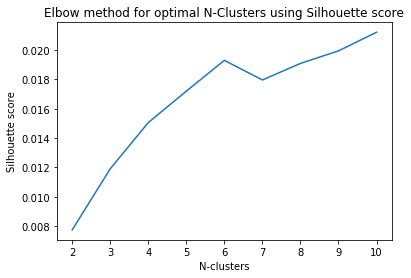

In [12]:
error = []
silhouette_scores = []
K = range(2,11)
for k in tqdm(K):
    topics = list(range(1, k + 1))
    labels = []
    nmf_model = NMF(k)
    doc_topic_nmf = nmf_model.fit_transform(doc_word_tf_idf)
    
    for record in doc_topic_nmf:
        label = topics[np.argmax(record)]
        labels.append(label)
    silhouette_scores.append(silhouette_score(df_for_modeling, labels))

plt.plot(K, silhouette_scores)
plt.xlabel('N-clusters')
plt.ylabel('Silhouette score')
plt.title('Elbow method for optimal N-Clusters using Silhouette score')
plt.show()

In [13]:
N_TOPICS = 6
topics = list(range(1, N_TOPICS + 1))

In [14]:
nmf_model = NMF(N_TOPICS)
doc_topic_nmf = nmf_model.fit_transform(doc_word_tf_idf)

In [15]:
df_w_labels = raw_df.copy()
labels = []

for index, row in raw_df.iterrows():
    text_vect = tf_idf.transform([row['cleaned_text']])
    result = nmf_model.transform(text_vect)
    label = topics[np.argmax(result)]
    labels.append(label)

In [16]:
df_w_labels['label'] = labels

### 3. Keywords & Examples

Посмотрим на ключевые слова и примеры из образовавшихся кластеров, чтобы попробовать определить, чем они отличаются друг от друга.

In [17]:
feature_names = tf_idf.get_feature_names()
for ix, topic in enumerate(nmf_model.components_):
    print("\nTopic ", ix + 1)
    print(", ".join([feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]))


Topic  1
остаток, узнать остаток, узнать, остаток минута, остаток пакет, пакет, минута, тариф, сатурн, тариф сатурн, остаток тариф, проверить, проверить остаток, минута тариф, трафик

Topic  2
стоить, сколько стоить, сколько, стоить минута, разговор, минута разговор, минута, роуминг, стоить звонок, позвонить, стоить позвонить, стоить перейти, перейти, стоить роуминг, тариф

Topic  3
сим, карта, сим карта, работать, телефон, сеть, работать сим, видеть, симка, телефон видеть, делать, купить, мочь, активировать, карта работать

Topic  4
пин, код, пин код, интернет, настройка, забыть, настройка интернет, забыть пин, отключить, делать, помнить, восстановить, узнать пин, взять, отключить пин

Topic  5
звонок, тариф, плутон, тариф плутон, стоимость, оператор, стоимость звонок, стоять, сатурн, сколько стоять, тариф сатурн, сфера, стоять звонок, звонок тариф, роуминг

Topic  6
остаться, минута, сколько, сколько остаться, узнать сколько, остаться минута, сколько минута, узнать, минута остаться,

In [18]:
for topic in topics:
    print('Topic num: ', topic)
    for value in df_w_labels[df_w_labels['label'] == topic]['text'].sample(5, random_state=42).values:
        print(value)
    print()

Topic num:  1
Где я могу получить информацию по остатку интернета? Мой тариф Сатурн
Как узнать остаток трафика на тарифе Плутон?
Привет. Как мне узнать, остаток бесплатных минут в тарифе Сатурн? Спасибо.
какое сообщение на короткий номер нужно послать чтоб узнать остаток пакетов?
Где я могу прочитать, какие остатки на моем тарифе "Сатурн"?

Topic num:  2
Сколько мне будет стоить позвонить в Испанию
собираюсь перейти на тариф Амур, но не понимаю, сколько стоит это?
Сколько стоит минута разговора на тарифе Плутон
 Приветствую если я перейду на Вулкан и буду звонить за рубеж мужу (в Британию) он абонент Сфера в роуминге то во сколько мне обойдётся минута общения? 
Привет, за границу звонить и писать смс сколько нужно платить на Геркулес.

Topic num:  3
Телефон не зарегистрирован в сети
Телефоно не хочет подключаться к вашей симке
Что делать если телефон не видит сеть?
Вставил сим карту с номером +79772566503. Пишет, что сеть недоступна. Что делать?
Выдает — нет регистрации в сети. Какого 

###  4. Выводы: 
 - темы 1 и 6 очень похожи, в обеих вопросы про остатки баланса, возможно, есть смысл заменить слово "остаться" на "остаток" на этапе предобработки, либо просто объединить их в одну
 - тема 2 - вопросы про стоимость
 - тема 3 - все, что связано с сим-картами и качеством связи
 - тема 4 - все, что связано с пин-кодами и интернетом
 - тема 5 - вопросы про конкретные тарифы, похожа на тему 2

In [19]:
topic_names = {
    1: "balance_1",
    2: "costs",
    3: "sim-cards",
    4: "pin-codes",
    5: "tariffs",
    6: "balance_2"
}

In [20]:
df_w_labels['topic_name'] = df_w_labels['label'].map(topic_names)

In [21]:
# количество записей в каждом кластере
df_w_labels['topic_name'].value_counts()

tariffs      1155
sim-cards    718 
pin-codes    416 
balance_1    392 
costs        391 
balance_2    378 
Name: topic_name, dtype: int64

In [22]:
df_w_labels.head()

,text,cleaned_array,cleaned_text,label,topic_name
0,чего там надо платить за роуминг?,"[платить, роуминг]",платить роуминг,2,costs
1,сколько я проговорил минут в этом месяце на тарифе Плутон. Можешь помочь?,"[сколько, проговорить, минута, это, месяц, тариф, плутон, мочь, помочь]",сколько проговорить минута это месяц тариф плутон мочь помочь,5,tariffs
2,не могли бы вы мне пин напомнить?,"[мочь, пин, напомнить]",мочь пин напомнить,4,pin-codes
3,"да, спасибо! а какой пин для настроек интернета у нас?","[спасибо, пин, настройка, интернет]",спасибо пин настройка интернет,4,pin-codes
4,а откуда брать пин для телефона,"[откуда, брать, пин, телефон]",откуда брать пин телефон,4,pin-codes


### 5. Визуализация
Воспользуемся t-SNE как методом отображения многомерного пространства в двумерное - надеемся получить отдельные кластеры с минимумом пересечения.

In [23]:
tsne = TSNE(n_components=2, verbose=True, perplexity=45, n_iter=300, random_state=seed)
tsne_results = tsne.fit_transform(doc_topic_nmf)

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 3450 samples in 0.018s...
[t-SNE] Computed neighbors for 3450 samples in 0.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3450
[t-SNE] Computed conditional probabilities for sample 2000 / 3450
[t-SNE] Computed conditional probabilities for sample 3000 / 3450
[t-SNE] Computed conditional probabilities for sample 3450 / 3450
[t-SNE] Mean sigma: 0.007403
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.441612
[t-SNE] KL divergence after 300 iterations: 1.018845


Как и следовало ожидать: темы "balance_1" и "balance_2" расположены рядом и имеют пересечения, в то время как кластеры "sim-cards" и "pin-codes" расположены отдельно и (почти) не пересекаются с остальными.

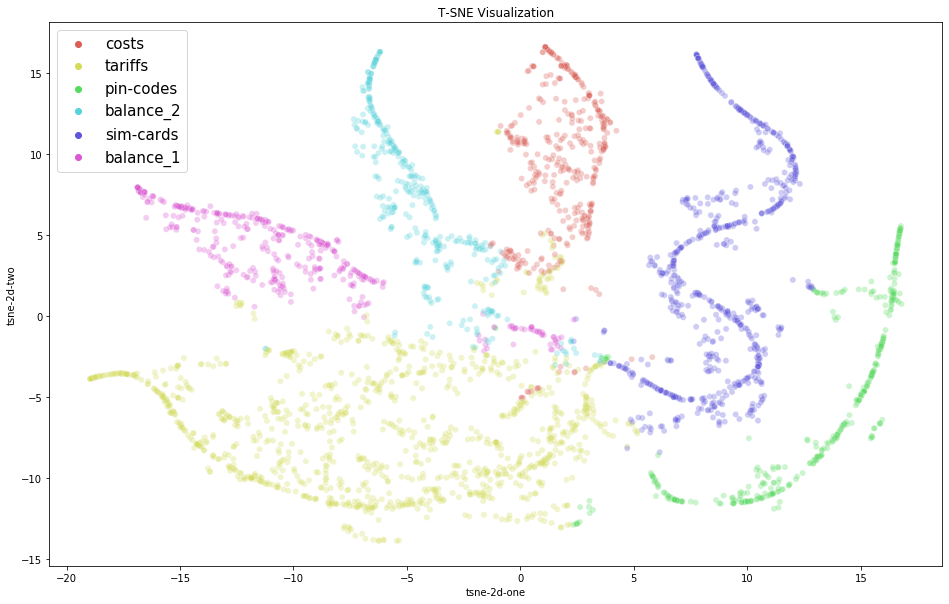

In [24]:
df_w_labels['tsne-2d-one'] = tsne_results[:,0]
df_w_labels['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="topic_name",
    palette=sns.color_palette("hls", df_w_labels['topic_name'].nunique()),
    data=df_w_labels,
    legend="full",
    alpha=0.3
)
plt.title('T-SNE Visualization')
plt.legend(loc=2, prop={'size': 15})

In [30]:
df_w_labels.to_csv('results.csv', index=False, sep=';')

In [31]:
import pickle 

pickle.dump( df_w_labels, open( "results.pkl", "wb" ) )